## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [229]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nx, ny = 9, 6

In [3]:
def calibrate_camera(imgs_path):
    images = glob.glob(imgs_path)
    objpoints, imgpoints = [], []
    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

In [4]:
objpoints, imgpoints = calibrate_camera('camera_cal/cali*.jpg')

In [5]:
def undistort_unwarp(images_path, objpoints, imgpoints, nx, ny):
    images = glob.glob(images_path)
    for fname in images:
        img = cv2.imread(fname)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        ret, corners = cv2.findChessboardCorners(undist, (nx, ny), None)
        if ret == True:
            img = cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
            offset = 100
            src = np.float32([corners[0], corners[nx-1], corners[-nx], corners[-1]])
            dst = np.float32([[offset, offset],
                              [img.shape[1] - offset, offset],
                              [offset, img.shape[0] - offset],
                              [img.shape[1] - offset, img.shape[0] - offset]])
            M = cv2.getPerspectiveTransform(src, dst)
            warped = cv2.warpPerspective(img, M, undist.shape[1::-1], flags=cv2.INTER_LINEAR)
            cv2.imshow("Warped", warped)
            cv2.waitKey(500)
    cv2.destroyAllWindows()

In [6]:
undistort_unwarp('camera_cal/cali*.jpg', objpoints, imgpoints, nx, ny)

In [170]:
img = cv2.imread('test_images/test2.jpg')

In [171]:
cv2.namedWindow("img", cv2.WINDOW_NORMAL)
cv2.resizeWindow("img", 600, 600)
cv2.imshow("img", img)

In [169]:
cv2.destroyAllWindows()

In [172]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

In [173]:
undist = cv2.undistort(img, mtx, dist, None, mtx)

In [174]:
offset = 10

In [175]:
pts = np.array([[96, 437],
                [1230, 437],
                [1230, undist.shape[0] - offset],
                [96, undist.shape[0] - offset]
                ], np.int32)

In [176]:
pts = pts.reshape((-1, 1, 2))

In [177]:
pol = cv2.polylines(undist, [pts], True, (0, 255, 255))

In [178]:
cv2.namedWindow("undist", cv2.WINDOW_NORMAL)
cv2.resizeWindow("undist", 600, 600)

In [179]:
cv2.imshow("undist", pol)

In [180]:
src = np.float32([[96, 437],
                  [1230, 437],
                  [1230, undist.shape[0]],
                  [96, undist.shape[0]]
                 ])


dst = np.float32([[offset, offset],
                 [undist.shape[1] - offset, offset],
                 [undist.shape[1] - offset, undist.shape[0] - offset],
                 [offset, undist.shape[0] - offset]])

In [181]:
M = cv2.getPerspectiveTransform(src, dst)

In [182]:
warped = cv2.warpPerspective(undist, M, undist.shape[1::-1], flags=cv2.INTER_LINEAR)

In [183]:
cv2.namedWindow("warped", cv2.WINDOW_NORMAL)
cv2.resizeWindow("warped", 600, 600)

In [212]:
cv2.imshow("warped", warped)

In [224]:
cv2.destroyAllWindows()

# Color Gradients

## Threshold gradient

In [230]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x',  thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobelabs = np.abs(sobel)
    scaledsobel = np.uint8(255*sobelabs/np.max(sobelabs))
    sbinary = np.zeros_like(scaledsobel)
    sbinary[(scaledsobel >= thresh[0]) & (scaledsobel <= thresh[1])] = 1
    return sbinary

In [256]:
gradx_binary = abs_sobel_thresh(warped, sobel_kernel=5, orient='x', thresh=(20, 100))

In [257]:
grady_binary = abs_sobel_thresh(warped, sobel_kernel=5, orient='y', thresh=(20, 100))

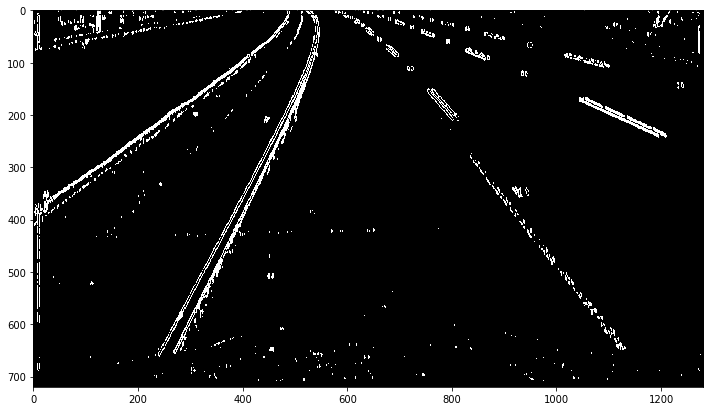

In [245]:
plt.figure(figsize=(12,10))
plt.imshow(grad_binary, cmap='gray')

## Magnitude of the Gradient

In [246]:
def mag_thresh(img, sobel_kernel=5, mag_thresh=(20, 200)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    magnitude = np.sqrt((sobelx)**2 + (sobely)**2)
    scaledsobel = np.uint8(255*magnitude/np.max(magnitude))
    sbinary = np.zeros_like(scaledsobel)
    sbinary[(scaledsobel >= mag_thresh[0]) & (scaledsobel <= mag_thresh[1])] = 1
    return sbinary

In [247]:
mag_img = mag_thresh(warped)

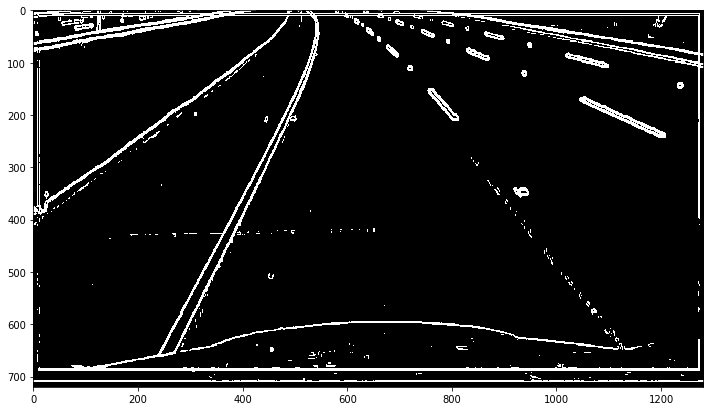

In [250]:
plt.figure(figsize=(12,10))
plt.imshow(mag_img, cmap='gray')

In [252]:
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output

In [254]:
dir_binary = dir_threshold(warped, sobel_kernel=5, thresh=(0.7, 1.3))

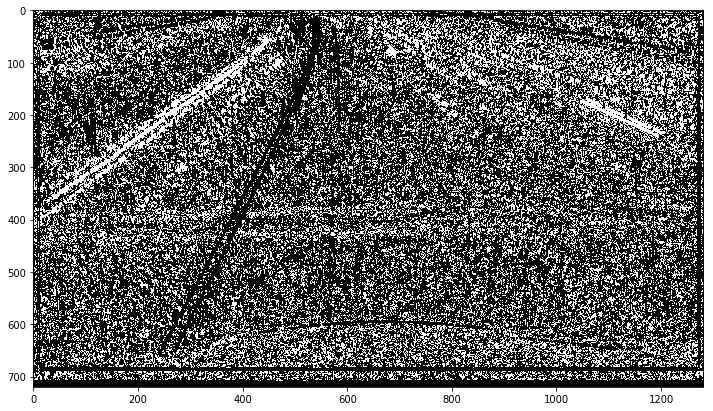

In [255]:
plt.figure(figsize=(12,10))
plt.imshow(dir_binary, cmap='gray')

In [258]:
combined = np.zeros_like(dir_binary)

In [259]:
combined[((gradx_binary == 1) & (grady_binary == 1)) | ((mag_img == 1) & (dir_binary== 1))] = 1

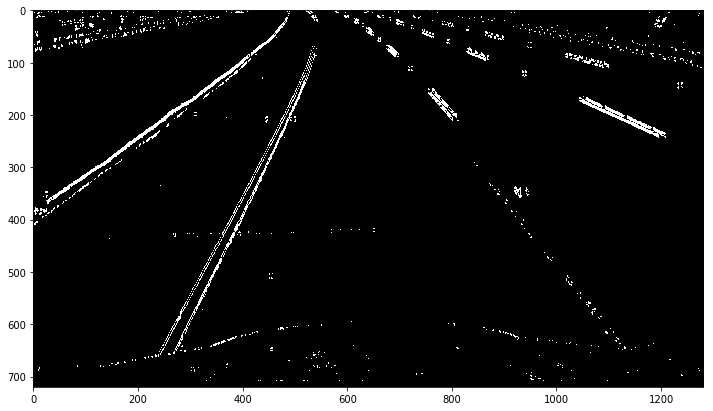

In [260]:
plt.figure(figsize=(12,10))
plt.imshow(combined, cmap='gray')

# Color Thresholding

In [261]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    return binary_output

In [267]:
hls_binary = hls_select(warped, thresh=(90, 255))

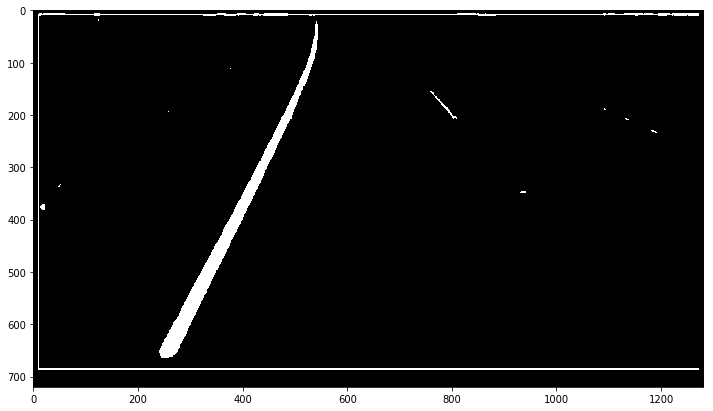

In [268]:
plt.figure(figsize=(12, 10))
plt.imshow(hls_binary, cmap='gray')

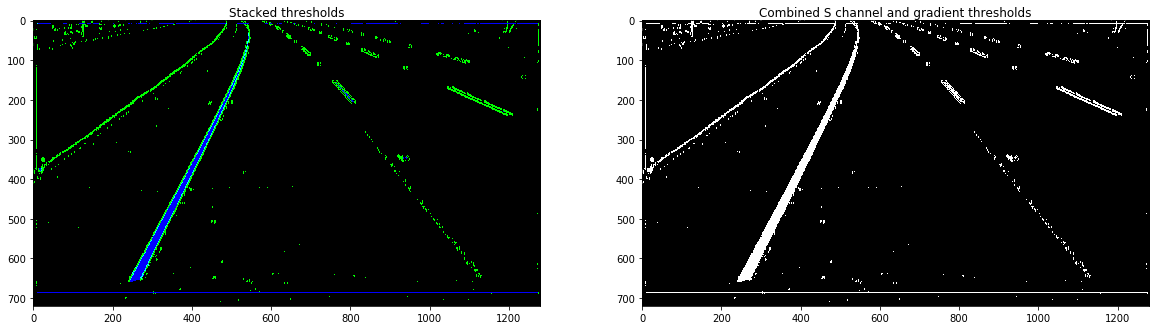

In [269]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

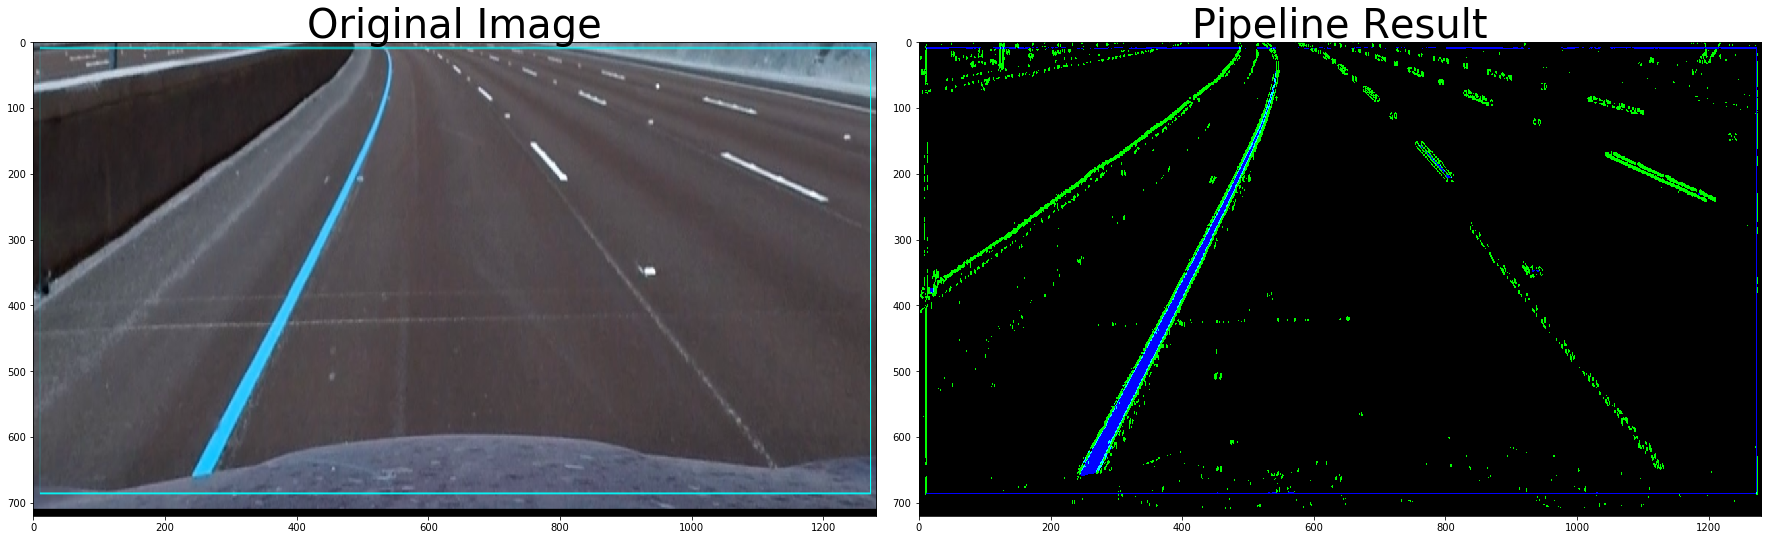

In [271]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary
    
result = pipeline(warped)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)